In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

/home/magic/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,Date,store,product,number_sold
0,2010-01-01,0,0,801
1,2010-01-02,0,0,810
2,2010-01-03,0,0,818
3,2010-01-04,0,0,796
4,2010-01-05,0,0,808


In [4]:
test.head()

,Date,store,product,number_sold
0,2019-01-01,0,0,845
1,2019-01-02,0,0,851
2,2019-01-03,0,0,840
3,2019-01-04,0,0,842
4,2019-01-05,0,0,845


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230090 entries, 0 to 230089
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Date         230090 non-null  object
 1   store        230090 non-null  int64 
 2   product      230090 non-null  int64 
 3   number_sold  230090 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.0+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25550 entries, 0 to 25549
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         25550 non-null  object
 1   store        25550 non-null  int64 
 2   product      25550 non-null  int64 
 3   number_sold  25550 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 798.6+ KB


In [7]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

# Выполнение агрегации по месяцам
train_aggregated = train.resample('M', on='Date')['number_sold'].sum().reset_index()
test_aggregated = test.resample('M', on='Date')['number_sold'].sum().reset_index()

In [8]:
train_aggregated.set_index('Date', inplace=True)
test_aggregated.set_index('Date', inplace=True)

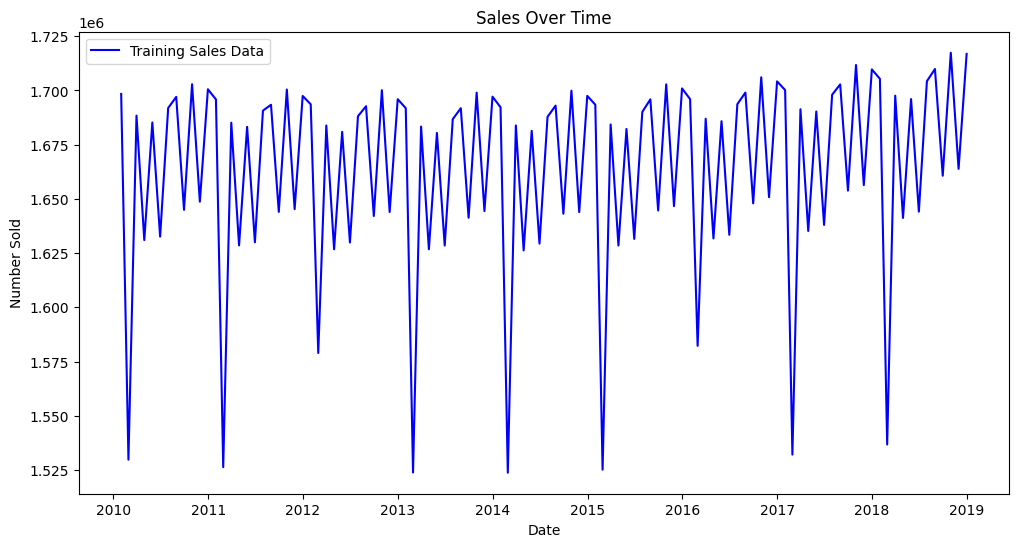

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(train_aggregated, label='Training Sales Data', color='blue')
plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.title('Sales Over Time')
plt.legend()
plt.show()

In [10]:
result = adfuller(train_aggregated['number_sold'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 0.5343272139492738
p-value: 0.9858799331312138


In [11]:
train_diff = train_aggregated['number_sold'].diff().dropna()
result_diff = adfuller(train_diff)
print('ADF Statistic after differencing:', result_diff[0])
print('p-value after differencing:', "{:.10f}".format(result_diff[1]))

ADF Statistic after differencing: -28.855441988661347
p-value after differencing: 0.0000000000


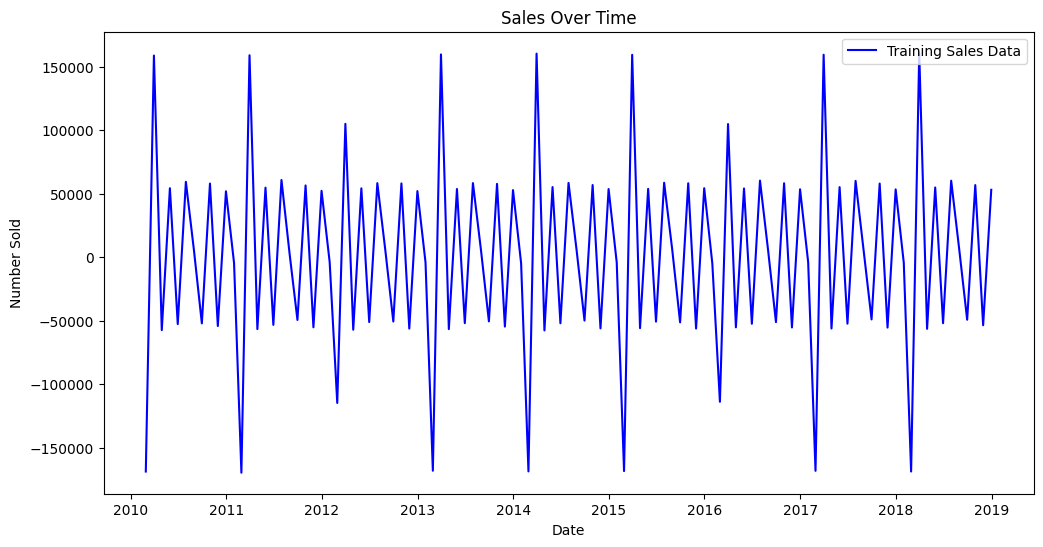

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(train_diff, label='Training Sales Data', color='blue')
plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.title('Sales Over Time')
plt.legend()
plt.show()

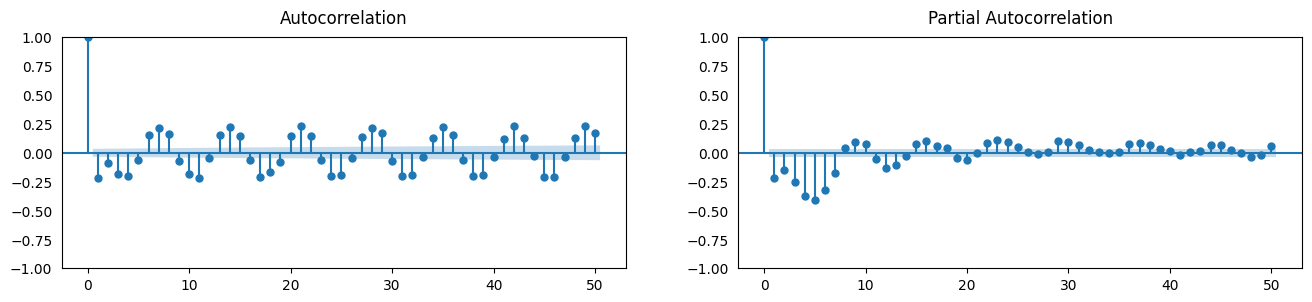

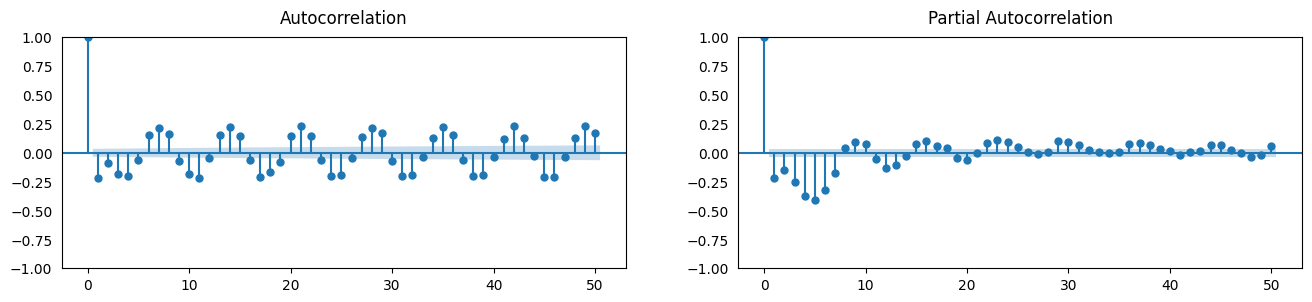

In [29]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(train_diff.tolist(), lags=50, ax=axes[0])
plot_pacf(train_diff.tolist(), lags=50, ax=axes[1])

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
import numpy as np

# Определяем параметры модели (p, d, q) и (P, D, Q, s)
# Для SARIMA определите s исходя из частоты (12 для месячных данных)
p, d, q = 5, 1, 5
P, D, Q, s = 1, 1, 1, 12

# Обучение модели
model = SARIMAX(train_aggregated['number_sold'], order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model.fit(disp=False)

# Прогноз
predictions = model_fit.forecast(steps=len(test_aggregated))


/home/magic/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/magic/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/magic/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/magic/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/magic/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009

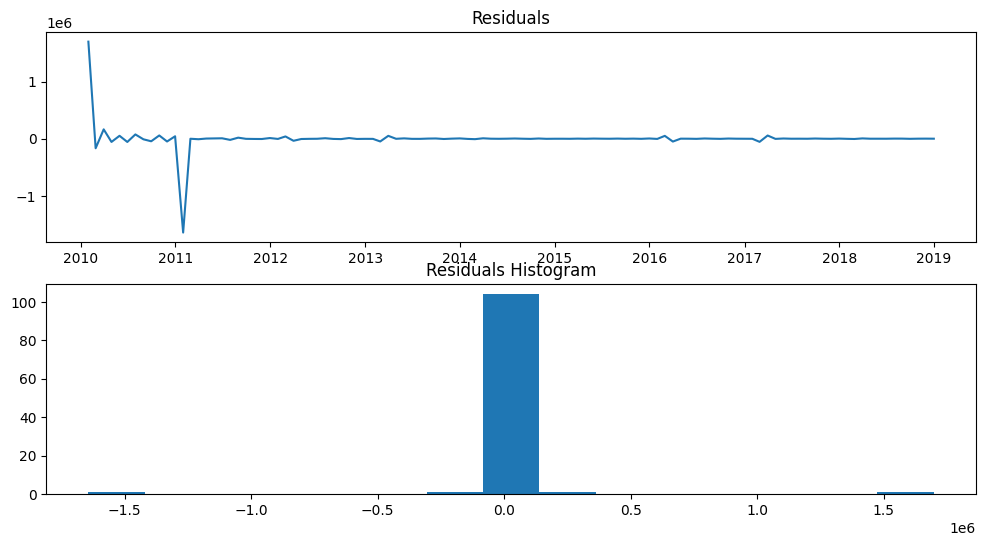

In [26]:
residuals = model_fit.resid

plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(residuals)
plt.title('Residuals')
plt.subplot(212)
plt.hist(residuals, bins=15)
plt.title('Residuals Histogram')
plt.show()

In [27]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

# Метрики
mape = mean_absolute_percentage_error(test_aggregated['number_sold'], predictions)
rmse_value = np.sqrt(mean_squared_error(test_aggregated['number_sold'], predictions))
r2 = r2_score(test_aggregated['number_sold'], predictions)

print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse_value:.2f}')
print(f'R²: {r2:.2f}')


MAPE: 0.00%
RMSE: 2546.64
R²: 1.00
